# TRENDYOL RECOMMENDATION ENGINE CAPSTONE PROJECT

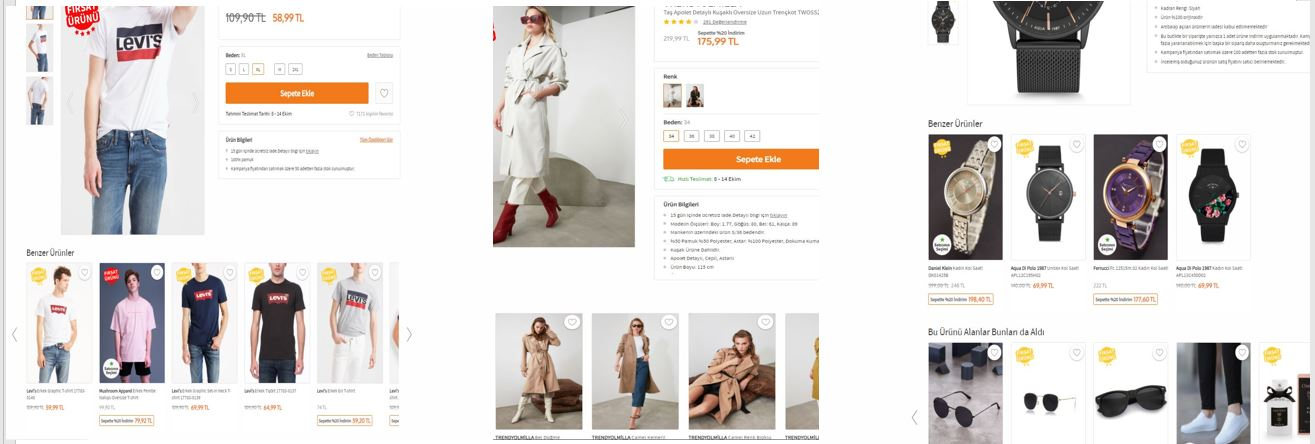

## 1. INTRODUCTION

Popularity due to a comfortable and effective online shopping experience provides companies additional data to improve their sales and costumer satisfaction. Particularly during this Covid-19 Pandemic, demand for purchasing online is on the rise. 
 
This growing trend has also lead companies to offer customers improved solutions using machine learning and data analysis tools. One of the biggest boons come from its usage in recommendation systems. These days, as customers, windows under purchases saying *'Similar products'* or  *'Customers who bought this also bought these*' are a familiar sight.  Recommendations have become commonplace to the user experience.

In this notebook, I worked with purchasing data from one of Turkey's biggest e-trade and fashion companies, **Trendyol**, to demonstrate machine learning tools and algorithms behind recommendation systems.
 
In this notebook, the 2 most popular recommendation filtering systems were applied.


*   Content Based Filtering System
*   Collaborative Filtering System








## 2. CATEGORY BASED RANKING RECOMMENDER SYSTEM

Most  recommendation engines need to have memory based data. Which means all items should have user interactions within a weighted ranking system. As the Trendyol dataset doesn't have interactions such as clickstreams, 'moved to the basket,' or ratings, we built weights from simple purchasing amounts.

I'll start with exploring the data and finding benefical columns to estimate weight.

In [8]:
import pandas as pd

In [9]:
df=pd.read_csv('https://storage.googleapis.com/ty2020/reco.csv.gz')

Our data set is mostly full, and nan values are almost not exist. Although this is really useful, we don't need all of the columns for now.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508228 entries, 0 to 508227
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   partition_date    508228 non-null  object 
 1   orderparentid     508228 non-null  int64  
 2   user_id           508228 non-null  int64  
 3   productcontentid  508228 non-null  int64  
 4   brand_id          508228 non-null  int64  
 5   category_id       508228 non-null  int64  
 6   category_name     508228 non-null  object 
 7   gender            475493 non-null  object 
 8   price             508228 non-null  float64
 9   color_id          375670 non-null  float64
 10  business_unit     508228 non-null  object 
 11  ImageLink         508228 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 46.5+ MB


In [11]:
df.head()

,partition_date,orderparentid,user_id,productcontentid,brand_id,category_id,category_name,gender,price,color_id,business_unit,ImageLink
0,20.08.2020 06:00,335057357,86386,39328996,919155,418,Sandalet,Kadın,319.98,14.0,Branded Shoes B,https://cdn.dsmcdn.com//ty1/product/media/imag...
1,24.08.2020 10:00,337401625,59469,31903343,121,1827,Banyo Dolabı,Unisex,1195.56,3.0,Bahçe & Yapı Market & Hırdavat,https://cdn.dsmcdn.com//assets/product/media/i...
2,26.08.2020 19:00,338457012,51248,34726400,40,604,T-Shirt,Kadın,37.99,14.0,PL Woman,https://cdn.dsmcdn.com//assets/product/media/i...
3,22.08.2020 11:00,336681542,29380,32920640,7651,604,T-Shirt,Kadın,24.99,6.0,Kadın A,https://cdn.dsmcdn.com//assets/product/media/i...
4,20.08.2020 19:00,335736916,68368,39035716,3395,599,Kazak,Kadın,79.90,16.0,Kadın A,https://cdn.dsmcdn.com//ty1/product/media/imag...


In [12]:
df.tail(10)

,partition_date,orderparentid,user_id,productcontentid,brand_id,category_id,category_name,gender,price,color_id,business_unit,ImageLink
508218,1.08.2020 19:00,325912035,19547,31076500,953433,934,Avize,Unisex,259.00,4.0,Aydınlatma,https://cdn.dsmcdn.com//assets/product/images/...
508219,12.08.2020 08:00,330211854,69402,32919087,13025,525,Eşofman Altı,Kadın,49.99,14.0,Kadın B,https://cdn.dsmcdn.com//ty1/product/media/imag...
508220,28.07.2020 00:00,324345089,55671,3052680,5085,2247,Tek Kişilik Nevresim,Unisex,79.90,12.0,Ev Tekstil,https://cdn.dsmcdn.com//Assets/ProductImages/o...
508221,7.08.2020 13:00,328355157,87535,1762168,15663,3452,Fırça,Unisex,52.75,NaN,Kırtasiye & Ofis,https://cdn.dsmcdn.com//ty11/product/media/ima...
508222,2.08.2020 10:00,326029540,59112,36420255,835853,1516,Yaka Kartı & Aksesuarları,Unisex,29.00,NaN,Kırtasiye & Ofis,https://cdn.dsmcdn.com//assets/product/media/i...
508223,5.08.2020 14:00,327329628,82960,40176648,8820,419,Terlik,Kadın,49.99,3.0,Branded Shoes B,https://cdn.dsmcdn.com//ty3/product/media/imag...
508224,1.08.2020 22:00,325950933,35173,35247547,40,604,T-Shirt,Kadın,25.99,3.0,PL Woman,https://cdn.dsmcdn.com//assets/product/media/i...
508225,24.08.2020 09:00,337358492,14468,34919558,4951,594,Ceket,Kadın,169.95,3.0,Kadın A,https://cdn.dsmcdn.com//ty10/product/media/ima...
508226,30.07.2020 14:00,325286010,37697,41172873,21955,1278,Su Sebili,NaN,868.50,14.0,Beyaz Eşya,https://cdn.dsmcdn.com//ty3/product/media/imag...
508227,2.08.2020 14:00,326112457,69563,32720825,19,599,Kazak,Erkek,79.95,8.0,GAS Casual,https://cdn.dsmcdn.com//assets/product/media/i...


In [13]:
#later on this notebook used this code to able to click to image links
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


Since this is a simple purchaces table we need to estimate a ranking value. At first look, I need to decide which columns are useful to estimate it. I have user_id which shows me a customers' purchaces within a month. I have category_names which shows me what product a user bought. Also I have business_unit which helps me to determine more detailed information about the product user bought. For example if we wouldn't have business_unit we couldn't idetify a T-Shirt from its category name. Gender is not enough to explain the users profile. A product can still belong to the kids category but we can't seperate it without business_unit. That's why im creating a new dataframe with useful columns for the first recommendations.

In [14]:
#unnucessary columns dropped for now
case1=df.drop(['partition_date','orderparentid','user_id','color_id', 'gender','price'],axis=1)

In [15]:
case1.describe()

,productcontentid,brand_id,category_id
count,5.082280e+05,508228.000000,508228.000000
mean,2.879870e+07,140954.121625,1343.289565
std,1.543470e+07,311760.192065,958.158961
min,5.197100e+04,9.000000,369.000000
25%,6.981131e+06,3266.000000,601.000000
50%,3.546958e+07,12542.000000,967.000000
75%,3.982106e+07,33798.000000,2019.000000
max,4.707305e+07,993236.000000,4086.000000


In [16]:
#using sql connection is easy way to implement bigger datas.
import sqlite3
conn=sqlite3.connect(":memory:")

In [17]:
case1.to_sql("case1",conn,if_exists='replace')

The best way to estimate a ranking value from this data set is by finding their number of purchaces. After that we can evaluate thir weight compared to other items.

In [18]:
#small DataFrame just to implemnt weights accroding to business_unit
buss_u= pd.read_sql(
    """
    select business_unit, count(1) n
    from case1
    group by business_unit
    order by n desc
    """,conn
)

In [19]:
buss_u['weight']= buss_u[['n']].transform(lambda x: x/x.sum()) # number of item/total purchaces within business_unit categorys.
buss_u


,business_unit,n,weight
0,PL Woman,43736,0.086056
1,Kadın B,32107,0.063174
2,Kadın A,31882,0.062732
3,Kids & Baby Fashion,26710,0.052555
4,Sofra & Mutfak,23530,0.046298
...,...,...,...
81,Hamile Giyim,3,0.000006
82,Mobilya,3,0.000006
83,Kozmetik,2,0.000004
84,Lüks & Tasarım,1,0.000002


In [20]:
#don't need n after weight.if it stays might cuase wrong information after merging with main datframe
buss_u=buss_u.drop('n',axis=1)

In [21]:
#Merging with main DataFrame made it has a weight score-which is for craeting a ranking system-
df1=df.merge(buss_u,on=['business_unit']).sort_values('weight',ascending=False)

We found the first rating of our own(!), but is it enough to make a seperate value for every item? No for now. As we can see from business_unit, for example, PL Woman has so many different category_names.To take their existince into account, we need their weight as well.

In [22]:
df1.head()

,partition_date,orderparentid,user_id,productcontentid,brand_id,category_id,category_name,gender,price,color_id,business_unit,ImageLink,weight
43248,20.08.2020 08:00,335145467,34014,31515569,40,531,Tayt,Kadın,44.99,14.0,PL Woman,https://cdn.dsmcdn.com//assets/product/media/images/20200318/15/4523355/56696304/1/1_org_zoom.jpg,0.086056
36198,21.08.2020 19:00,336438400,15409,38078412,40,1182,Elbise,Kadın,79.99,12.0,PL Woman,https://cdn.dsmcdn.com//ty1/product/media/images/20200506/14/735071/67628500/2/2_org_zoom.jpg,0.086056
36200,19.08.2020 12:00,334497921,110679,37427492,40,526,Etek,Kadın,59.99,11.0,PL Woman,https://cdn.dsmcdn.com//ty1/product/media/images/20200424/20/201449/66449170/2/2_org_zoom.jpg,0.086056
36201,31.07.2020 17:00,325605386,71077,36545811,40,590,Bluz,Kadın,49.99,14.0,PL Woman,https://cdn.dsmcdn.com//assets/product/media/images/20200317/11/4477571/65062163/1/1_org_zoom.jpg,0.086056
36202,30.07.2020 19:00,325377825,62352,35627433,40,604,T-Shirt,Kadın,24.99,11.0,PL Woman,https://cdn.dsmcdn.com//assets/product/media/images/20200319/11/4541828/63695936/1/1_org_zoom.jpg,0.086056


In [23]:
#a weight just coming from business_unit is not relaible to improve it also looked for category based weight
category=pd.read_sql(
    """
    select category_name, business_unit, count(1) n
    from case1
    group by  category_name ,business_unit
    order by n desc
    """
    ,conn)

In [24]:
category.sort_values('n',ascending=False) 

,category_name,business_unit,n
0,T-Shirt,PL Woman,15938
1,Elbise,PL Woman,9831
2,Medikal Maske,Sağlık,8869
3,T-Shirt,Kadın A,8468
4,T-Shirt,PL Erkek,6899
...,...,...,...
4156,Ev Sinema Sistemi,TV & Görüntü Ses Sistemleri,1
4157,Ev Terliği,Erkek A,1
4158,Ev Terliği,Luxury,1
4159,Ev Tüketim Malzemeleri,Diğer Aksesuarlar,1


In [25]:
category['weight']=category[['n']].transform(lambda x: x/x.sum())
category.sort_values('weight',ascending=False)

,category_name,business_unit,n,weight
0,T-Shirt,PL Woman,15938,0.031360
1,Elbise,PL Woman,9831,0.019344
2,Medikal Maske,Sağlık,8869,0.017451
3,T-Shirt,Kadın A,8468,0.016662
4,T-Shirt,PL Erkek,6899,0.013575
...,...,...,...,...
4156,Ev Sinema Sistemi,TV & Görüntü Ses Sistemleri,1,0.000002
4157,Ev Terliği,Erkek A,1,0.000002
4158,Ev Terliği,Luxury,1,0.000002
4159,Ev Tüketim Malzemeleri,Diğer Aksesuarlar,1,0.000002


In [26]:
category=category.drop('n',axis=1)

In [27]:
#now also merging with last used DataFrame helped having more accurate ranking system
df2=df1.merge(category,on=['category_name','business_unit']).sort_values('weight_y',ascending=False)

In [28]:
df2.head()

,partition_date,orderparentid,user_id,productcontentid,brand_id,category_id,category_name,gender,price,color_id,business_unit,ImageLink,weight_x,weight_y
32980,17.08.2020 11:00,332656280,56062,35608512,40,604,T-Shirt,Kadın,29.99,21.0,PL Woman,https://cdn.dsmcdn.com//assets/product/media/images/20200319/11/4541828/63638236/1/1_org_zoom.jpg,0.086056,0.03136
26723,3.08.2020 12:00,326401562,66326,35627433,40,604,T-Shirt,Kadın,24.99,11.0,PL Woman,https://cdn.dsmcdn.com//assets/product/media/images/20200319/11/4541828/63695936/1/1_org_zoom.jpg,0.086056,0.03136
17820,25.08.2020 11:00,337845287,18882,35654732,40,604,T-Shirt,Kadın,44.99,11.0,PL Woman,https://cdn.dsmcdn.com//assets/product/media/images/20200302/13/3955976/63744198/1/1_org_zoom.jpg,0.086056,0.03136
17819,18.08.2020 19:00,333934692,79608,37634819,40,604,T-Shirt,Kadın,39.99,3.0,PL Woman,https://cdn.dsmcdn.com//ty2/product/media/images/20200410/12/1553582/66906957/1/1_org_zoom.jpg,0.086056,0.03136
17818,20.08.2020 19:00,335728753,89750,37805207,40,604,T-Shirt,Kadın,39.99,3.0,PL Woman,https://cdn.dsmcdn.com//ty1/product/media/images/20200415/12/1877048/67202489/2/2_org_zoom.jpg,0.086056,0.03136


We took into account categories as well; however, we had multiple weights to fix the ranking applied as follows.

In [29]:
#to estimate unique weight used both weight_x from business_unit, weight_y from category_name
alpha=0.8
df2['weight'] = alpha* df2.weight_x + (1-alpha) * df2.weight_y

In [30]:
df2=df2.drop(['weight_x','weight_y'],axis=1)

In [31]:
#with sorting weights we had first best selling products recommendation
reco=df2.sort_values('weight',ascending=False)

In [33]:
reco[['user_id','category_name','business_unit','weight']].head(10)

,user_id,category_name,business_unit,weight
32980,56062,T-Shirt,PL Woman,0.075117
21648,76223,T-Shirt,PL Woman,0.075117
21609,73007,T-Shirt,PL Woman,0.075117
21631,2289,T-Shirt,PL Woman,0.075117
21633,54092,T-Shirt,PL Woman,0.075117
21657,16169,T-Shirt,PL Woman,0.075117
21646,104006,T-Shirt,PL Woman,0.075117
21656,42060,T-Shirt,PL Woman,0.075117
21655,109762,T-Shirt,PL Woman,0.075117
21654,94171,T-Shirt,PL Woman,0.075117


Finally we have our weights to determine the most populer products in this case!

Our most basic recommendation system was for generating results for unknown users without an account. This system displayed the most popular products sold so far. The table above shows that T-Shirts are dominating the top results. To see different products from each category we can drop duplicates.

In [112]:
#to see one product from each category ,kept single values.
reco_final=reco.drop_duplicates(subset='category_name', keep="first")
reco_final.head(10)

,partition_date,orderparentid,user_id,productcontentid,brand_id,category_id,category_name,gender,price,color_id,business_unit,ImageLink,weight
32980,17.08.2020 11:00,332656280,56062,35608512,40,604,T-Shirt,Kadın,29.99,21.0,PL Woman,https://cdn.dsmcdn.com//assets/product/media/images/20200319/11/4541828/63638236/1/1_org_zoom.jpg,0.075117
10788,18.08.2020 01:00,333156439,87754,35729015,40,1182,Elbise,Kadın,69.99,8.0,PL Woman,https://cdn.dsmcdn.com//assets/product/media/images/20200229/21/3955845/63846607/1/1_org_zoom.jpg,0.072713
12479,31.07.2020 17:00,325605386,71077,36545811,40,590,Bluz,Kadın,49.99,14.0,PL Woman,https://cdn.dsmcdn.com//assets/product/media/images/20200317/11/4477571/65062163/1/1_org_zoom.jpg,0.070918
35291,20.08.2020 10:00,335233614,104474,35166907,40,1186,Jeans,Kadın,99.99,9.0,PL Woman,https://cdn.dsmcdn.com//ty10/product/media/images/20200808/2/7478472/62787580/3/3_org_zoom.jpg,0.069529
11420,15.08.2020 06:00,331373767,22031,8671494,40,526,Etek,Kadın,19.99,14.0,PL Woman,https://cdn.dsmcdn.com//assets/dev/product/media/images/20200324/17/544/22377347/1/1_org_zoom.jpg,0.069487
43253,27.07.2020 09:00,324074250,41367,37757901,40,592,Body,Kadın,49.99,6.0,PL Woman,https://cdn.dsmcdn.com//ty2/product/media/images/20200421/9/31036/67124779/1/1_org_zoom.jpg,0.069354
41209,29.07.2020 18:00,325029426,52583,36875178,40,530,Şort & Bermuda,Kadın,59.99,9.0,PL Woman,https://cdn.dsmcdn.com//ty1/product/media/images/20200401/20/956587/65586327/1/1_org_zoom.jpg,0.069345
36410,7.08.2020 15:00,328400442,16933,3774857,40,529,Pantolon,Kadın,89.99,8.0,PL Woman,https://cdn.dsmcdn.com//ty10/product/media/images/20200823/19/8640740/15714606/2/2_org_zoom.jpg,0.069275
37695,22.08.2020 10:00,336662061,102461,43860550,40,597,Gömlek,Kadın,79.99,16.0,PL Woman,https://cdn.dsmcdn.com//ty7/product/media/images/20200731/16/6475125/77735623/1/1_org_zoom.jpg,0.069254
782,5.08.2020 23:00,327721388,59734,35466673,40,531,Tayt,Kadın,39.99,6.0,PL Woman,https://cdn.dsmcdn.com//assets/product/media/images/20200318/15/4523355/63276588/1/1_org_zoom.jpg,0.069245


In [113]:
import csv
reco_demo=reco_final.to_csv('reco_demo.csv') #this is for adding to streamlit as smaller data

To deploy this results in a web app, we can use this reco and the links in the column.







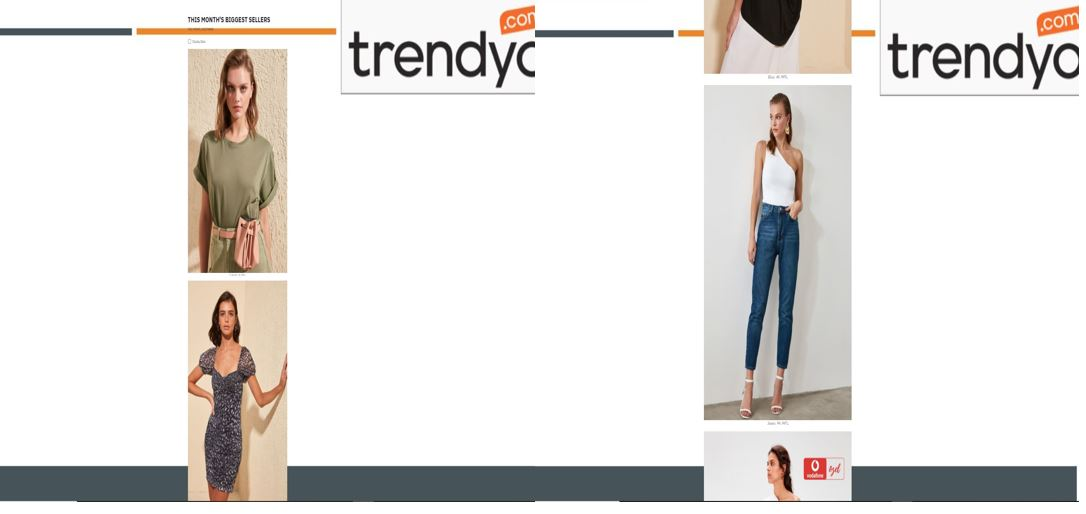


###2.1. EDA


Text(0.5, 1.0, 'Most Populer products by their weights')

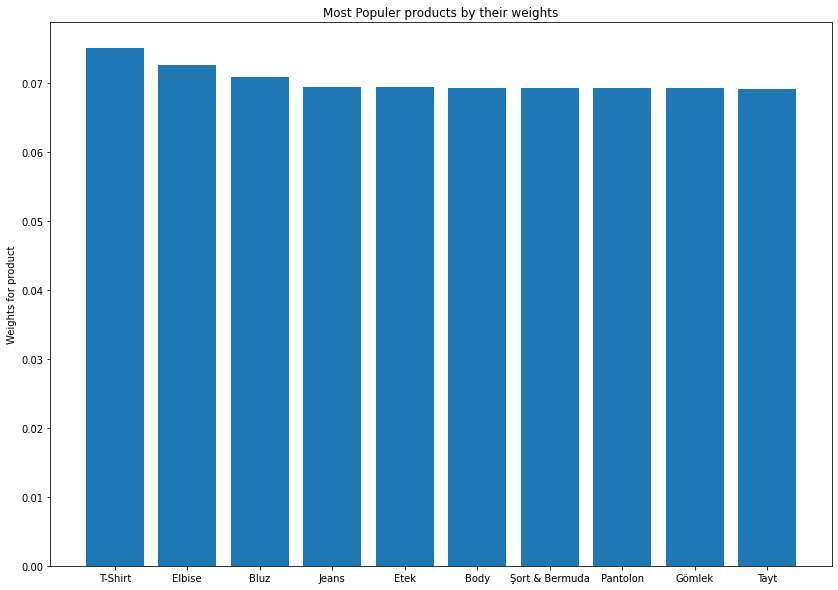

In [114]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,10))
plt.bar(x=reco_final['category_name'].head(10), height=reco_final['weight'].head(10) ,data=reco_final.head(10), align='center')
plt.ylabel("Weights for product")
plt.title("Most Populer products by their weights")

The  bar chart demonstates that using the items weight helped normalizing our data and not missing recommendations for other items. We can easily see that having weights as ranking, rather than just counting of the products, was a better way to make a ranking system within the dataset. Even though I dropped category names' duplications and kept single values, I can still see the difference in weights.


### 2.2. RESULTS

To display popular items based recommendation engines, this aproach might be helpful. In my case, new categories of user interactions and product information could improve it further. Especially these days in our increasingly technological world we have lots of different ways to collect data and improve our features to make better recommendations.

##3. CONTENT BASED  SYSTEM

As I mentioned earlier, demographic filtering is not so useful here.That's why i wanted to try generating a content-based non-ranking system. Actually nothing is non-rated in this recommendation world; however, content-based filtering methods can estimate ranking itself by using a bunch of different algorithms.

Content based filtering creates a matrix with indices of relational items. We have category_names and business_unit names in hand. We can use a count vectorizer to find their significance in the dataset.

I'll start with creating a new column including all words within our dataframe.

In [115]:
reco_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1879 entries, 32980 to 508087
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   partition_date    1879 non-null   object 
 1   orderparentid     1879 non-null   int64  
 2   user_id           1879 non-null   int64  
 3   productcontentid  1879 non-null   int64  
 4   brand_id          1879 non-null   int64  
 5   category_id       1879 non-null   int64  
 6   category_name     1879 non-null   object 
 7   gender            1635 non-null   object 
 8   price             1879 non-null   float64
 9   color_id          860 non-null    float64
 10  business_unit     1879 non-null   object 
 11  ImageLink         1879 non-null   object 
 12  weight            1879 non-null   float64
dtypes: float64(3), int64(5), object(5)
memory usage: 205.5+ KB


### 3.1. EDA

Words coming from columns include catgory_name, business_unit and gender. To handle the missing gender case, I chose to fill nans with the 'unisex' value.

In [116]:
reco_final['gender'].describe() 

count     1635  
unique    3     
top       Unisex
freq      1247  
Name: gender, dtype: object

In [117]:
reco_final[['gender']] = reco_final[['gender']].fillna(value='Unisex') #chose to fill nans with unisex which is most popular for my case

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [118]:
reco_final['detailed_description']=reco_final['category_name']+' '+reco_final['business_unit']+' '+reco_final['gender']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


To visualize what words are most common we can use wordcloud. We highlight top words as follows:


(-0.5, 799.5, 799.5, -0.5)

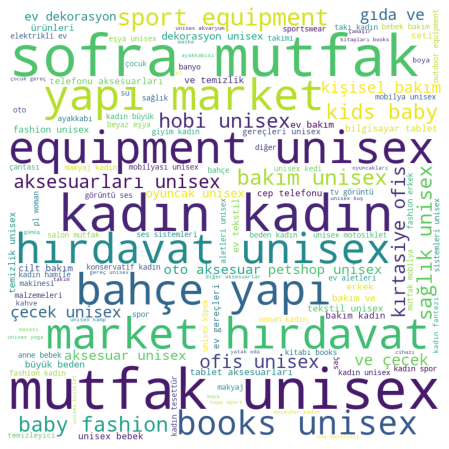

In [119]:
from wordcloud import WordCloud, STOPWORDS 

comment_words = '' 
stopwords = set(STOPWORDS) 
  
for val in reco_final['detailed_description']: 
      
    val = str(val) 
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
  

From the Spacy library we can implement stop_words methods in order to remove non valuable words to mix our indicies. To vectorize all the words and their indices we need to cut off unnecessary words like 'the' ,'a' ,'or'...  Spacy library has algorithms for stop words for many different languages.


In [120]:

from spacy.lang.tr.stop_words import STOP_WORDS as tr_stop # for turkish stop words
from spacy.lang.en.stop_words import STOP_WORDS as en_stop
from sklearn.feature_extraction.text import TfidfVectorizer

final_stopwords_list = list(tr_stop) + list(en_stop)



TF-IDF is an abbreviation for Term Frequency Inverse Document Frequency. This is very common algorithm to transform text into a meaningful numerical values to fit into a prediction model. In our case I used the detailed description column containing all the words from dataset.

In [121]:
#Defining a TF-IDF Vectorizer Object. Remove all  stop words  both in english and turkih 
tfidf = TfidfVectorizer(stop_words=final_stopwords_list)


In [122]:
tfidf_matrix = tfidf.fit_transform(reco_final['detailed_description'])

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [123]:
tfidf_matrix.shape

(1879, 1811)

After this point I tried using cosine similarty metric linear-kernel first, but it didn't give me proper results. Descriptive features from the dataframe such as color, size, and sub category do not provide enough information to make a proper prediction.
Then I decided to make a prediction with countvectorizer.


Cosine similarity is a measure of similarity that can be used to compare documents.

Each element of this is associated with a word in the array and its value is the number of times that word is found in the array in prompt. The cosine similarity is then computed between the two arrays, which, in our case, involves comparing all the single words with each other.


In [124]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words=final_stopwords_list)
count_matrix = count.fit_transform(reco_final['detailed_description'])


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [125]:
count_matrix.shape

(1879, 1811)

In [126]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(count_matrix, count_matrix)
print(cosine_sim)


[[1.   0.75 0.75 ... 0.25 0.25 0.25]
 [0.75 1.   0.75 ... 0.25 0.25 0.25]
 [0.75 0.75 1.   ... 0.25 0.25 0.25]
 ...
 [0.25 0.25 0.25 ... 1.   0.5  0.5 ]
 [0.25 0.25 0.25 ... 0.5  1.   0.5 ]
 [0.25 0.25 0.25 ... 0.5  0.5  1.  ]]


From cosine_sim matrix we can see that similar or same score owners' products should apper in same recommendation order.

The closer the documents are by angle, the higher the Cosine Similarity in this calculation.

In [127]:

reco_final = reco_final.reset_index()
indices = pd.Series(reco_final.index, index=reco_final['category_name'])

In [128]:
# Function that takes in category names as input and outputs most similar products
def get_recommendations(category_name):
    # Get the index of the product that matches the category_name
    idx = indices[category_name]

    # Get the pairwsie similarity scores 
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:11]

    product_indices = [i[0] for i in sim_scores]

    #  top 10 most similar products
    return (reco_final['category_name'].iloc[product_indices], reco_final['ImageLink'].iloc[product_indices])

With the help of this function we can give a category name and find out the 10 most related products to give as a recommendation!

In [129]:
get_recommendations('Saat')

(1655    Saat Seti        
 115     Boxer            
 140     Kravat           
 158     Eldiven          
 174     Slip             
 176     Patik            
 53      Bijuteri Bileklik
 114     Deniz Şortu      
 126     Plaj Havlusu     
 131     Spor Çantası     
 Name: category_name, dtype: object,
 1655    https://cdn.dsmcdn.com//ty2/product/media/images/20200504/17/634199/70125707/1/1_org_zoom.jpg    
 115     https://cdn.dsmcdn.com//assets/product/media/images/20200319/13/4529417/65764563/1/1_org_zoom.jpg
 140     https://cdn.dsmcdn.com//assets/product/media/images/20200129/10/2511411/62604074/1/1_org_zoom.jpg
 158     https://cdn.dsmcdn.com//ty9/product/media/images/20200807/18/7463388/79261034/1/1_org_zoom.jpg   
 174     https://cdn.dsmcdn.com//assets/product/media/images/20200129/10/2593403/62726680/1/1_org_zoom.jpg
 176     https://cdn.dsmcdn.com//assets/product/images2/243564/56461273/1/1_org_zoom.jpg                  
 53      https://cdn.dsmcdn.com//assets/product/med

### 3.2. RESULTS

Now we have "you might also like these" recommendation with the help of content-based filtering. The effciency of results can be shown on the list. When a user adds 'saat' into her/his basket, these can be other recommendations at the time. For example our cosine_matrix related 'saat' with mostly male products, which is also in need of improvement.Actually customer purchaces have many of unsupervised features. To specify better recommendations, especially for a particular user, we should try also user_id based predictions as well.

## 4. COLLABORATIVE RECOMMENDATION SYSTEM

Collaborative filtering is a family of algorithms where there are multiple ways to find similar users or items and multiple ways to calculate a rating based on the ratings of similar users. In our case its going to help make recommendations to the users from their previous purchaces. I chose to use the Surprise library and its algorithms to find the best model. According to my research about recommendation, the prediction algorithms within the Surprise library makes it one of the useful libraries for recommendation engines. On my first trial, I just found the SVD (Single Value Decomposition) algorithm but that one didn't give me  good predictions. Then I decided searching other algorithms as well.

In [130]:
#started with installing the library
!pip install surprise
from surprise import Reader, Dataset, SVD,SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise.model_selection import cross_validate


### 4.1 EDA

I started by create a sample data set from DataFrame with weights. Algorithms in this library also need ranking values to make correlations.

In [131]:
df_s=pd.DataFrame(reco.sample(12500)) #sample datframe from reco with weights to avoid RAM issues.

In [132]:
reco_demo2=df_s.to_csv('reco_demo2.csv') 

In [133]:
df_s


,partition_date,orderparentid,user_id,productcontentid,brand_id,category_id,category_name,gender,price,color_id,business_unit,ImageLink,weight
464049,25.08.2020 09:00,337785509,86086,42720044,14619,934,Avize,Unisex,76.77,3.0,Aydınlatma,https://cdn.dsmcdn.com//ty5/product/media/images/20200706/20/3840623/75940870/1/1_org_zoom.jpg,0.006479
303591,10.08.2020 09:00,329390785,20170,3633297,3426,1883,Düzenleyici,Unisex,13.51,3.0,Ev Gereçleri,https://cdn.dsmcdn.com//assets/product/media/images/20200203/15/2743575/15504129/1/1_org_zoom.jpg,0.013895
334469,27.07.2020 20:00,324300109,46920,37281102,10823,839,Havlu&Havlu Seti,Unisex,66.00,3.0,Banyo,https://cdn.dsmcdn.com//assets/dev/product/media/images/20200326/13/299841/66263384/1/1_org_zoom.jpg,0.012989
133720,11.08.2020 14:00,329962765,90280,4378166,15,448,Sırt Çantası,Unisex,105.00,3.0,Kids & Baby Fashion,https://cdn.dsmcdn.com//Assets/ProductImages/oa/47/4378166/1/4058032412311_1_org_zoom.jpg,0.042064
398308,9.08.2020 09:00,328985683,34436,44062271,2406,1359,Köpek Eğitim Ürünleri,Unisex,16.90,NaN,Petshop,https://cdn.dsmcdn.com//ty8/product/media/images/20200722/18/5639283/78042341/1/1_org_zoom.jpg,0.008496
...,...,...,...,...,...,...,...,...,...,...,...,...,...
284721,14.08.2020 10:00,331079358,48486,41687884,889405,842,Tablo,Unisex,59.80,14.0,Ev Dekorasyon,https://cdn.dsmcdn.com//ty9/product/media/images/20200826/15/8857516/73956370/1/1_org_zoom.jpg,0.017307
180191,17.08.2020 19:00,332970667,13597,34582040,138797,2882,Dermaroller,Unisex,17.50,14.0,Cilt Bakım,https://cdn.dsmcdn.com//ty5/product/media/images/20200714/10/4390557/61856825/1/1_org_zoom.jpg,0.027160
249685,31.07.2020 11:00,325521529,21803,31861831,2564,1016,Külot,Kadın,23.99,15.0,İç Giyim,https://cdn.dsmcdn.com//assets/product/media/images/20191008/10/338638/57293294/1/1_org_zoom.jpeg,0.018611
336239,19.08.2020 11:00,334440002,11916,44422757,973693,1828,Banyo Düzenleyici,Unisex,15.90,3.0,Banyo,https://cdn.dsmcdn.com//ty7/product/media/images/20200726/11/6017768/78692078/0/0_org_zoom.jpg,0.011741


In [134]:
df_s.describe()

,orderparentid,user_id,productcontentid,brand_id,category_id,price,color_id,weight
count,1.250000e+04,12500.000000,1.250000e+04,12500.000000,12500.000000,12500.000000,9224.000000,12500.000000
mean,3.316338e+08,64741.082080,2.852212e+07,140565.391680,1338.047200,89.405597,21.621422,0.026203
std,4.350691e+06,31212.498289,1.560053e+07,311298.196911,951.338586,230.894372,300.144681,0.020623
min,2.849459e+08,101.000000,5.200700e+04,12.000000,369.000000,0.680000,1.000000,0.000129
25%,3.279237e+08,39098.500000,6.873080e+06,3268.000000,601.000000,29.990000,3.000000,0.009674
50%,3.315898e+08,68814.000000,3.530351e+07,12980.000000,967.000000,49.990000,8.000000,0.018256
75%,3.354730e+08,91412.250000,3.981256e+07,33798.000000,1981.750000,89.990000,14.000000,0.042226
max,3.387607e+08,112534.000000,4.691517e+07,992561.000000,4047.000000,9699.000000,7011.000000,0.075117


I will deeply look at the data to want to make sure weights are distrubuted normally.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


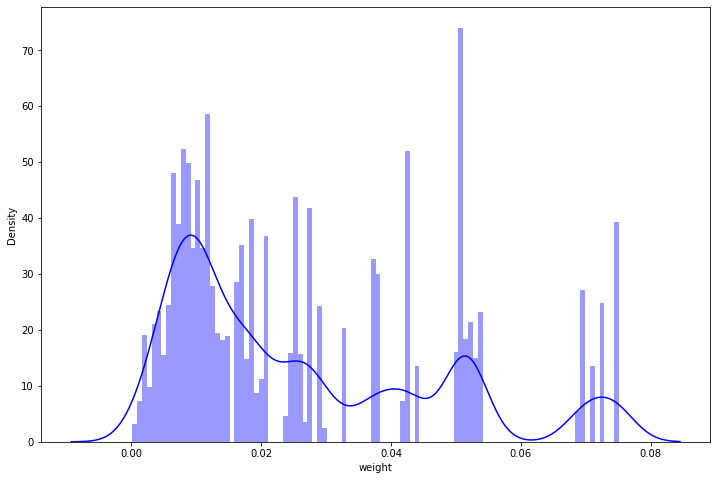

In [135]:
import seaborn as sns
plt.figure(figsize=(12,8))
sns.distplot(df_s['weight'], color='b', bins=100, hist_kws={'alpha': 0.4})

So far it looks normal and doesn't need to be normalized. We can continue  with these weights.

In [136]:
reader = Reader(rating_scale=(0,1))
data = Dataset.load_from_df(df_s[['user_id', 'productcontentid', 'weight']], reader)

In [137]:
# to choose best algorithm for user based recommendations
benchmark = []
# all algorithmns in surprise
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Scores with cross validation based on Root Mean Square Error
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)
    
    # Getting results from cross validation to a DataFrame
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

,test_rmse,fit_time,test_time
Algorithm,,,
KNNBaseline,0.019721,2.415495,0.016818
BaselineOnly,0.019734,0.053152,0.014345
KNNBasic,0.020618,2.202554,0.019631
KNNWithMeans,0.020763,2.281601,0.019117
SlopeOne,0.020788,2.191420,0.018591
KNNWithZScore,0.020805,2.591727,0.020052
CoClustering,0.021605,1.653928,0.013235
NMF,0.021649,2.215785,0.018170
SVDpp,0.022675,1.234359,0.016984


From the benchmark applied we can see that the KNNBaseline(collaborative filtering considering baseline rating) algorithm gives the best score according to our accuracy metric RMSE. So i'm gonna use this one to train a model.

In [138]:
#KNNBaseline gives the best results.
algo =KNNBaseline()
cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


{'fit_time': (2.312570810317993,
  2.1525990962982178,
  2.51476788520813,
  2.3037784099578857,
  2.2321650981903076),
 'test_rmse': array([0.02000585, 0.01975968, 0.01968856, 0.01969679, 0.01945548]),
 'test_time': (0.01737236976623535,
  0.01693439483642578,
  0.016502857208251953,
  0.018314361572265625,
  0.019013166427612305)}

After finding our algortihm we can go ahead with splitting the sample dataset into train and test data.


In [139]:
from surprise.model_selection import train_test_split
from surprise import accuracy
trainset, testset = train_test_split(data, test_size=.25)
#trainset = data.build_full_trainset()
algo=KNNBaseline()
algo.fit(trainset)
predictions =algo.test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.0196


0.019591937165993126

In [140]:
import numpy as np
def get_Iu(uid): #users bought items.
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: #to avoid having an error 'user not from the trainset.
        return 0
    
def get_Ui(iid): #item/products user bought.
    
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0


df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_pred['Iu'] = df_pred.uid.apply(get_Iu)
df_pred['Ui'] = df_pred.iid.apply(get_Ui)
df_pred['err'] =np.exp(-(df_pred.est - df_pred.rui)) #used exp to avaid extra small logaritmik numbers.
better_predictions =(pd.merge(df_pred,df_s[['productcontentid','category_name','ImageLink']], how='left',left_on=['iid'],right_on=['productcontentid'])).sort_values(by='err', ascending=True)[:10]
last_choice_predictions =(pd.merge(df_pred,df_s[['productcontentid','category_name','ImageLink']], how='left',left_on=['iid'],right_on=['productcontentid'])).sort_values(by='err', ascending=False)[:10]

In [141]:
better_predictions

,uid,iid,rui,est,details,Iu,Ui,err,productcontentid,category_name,ImageLink
2328,85115,35879900,0.001103,0.030962,{'was_impossible': False},111,0,0.970583,35879900,Klasik Topuklu Ayakkabı,https://cdn.dsmcdn.com//assets/product/media/images/20200304/9/4028718/64103513/1/1_org_zoom.jpg
4865,42607,2794743,0.000492,0.026307,{'was_impossible': False},0,0,0.974516,2794743,Omuz Çantası,https://cdn.dsmcdn.com//Assets/ProductImages/oa/88/2794743/2/T155002IL04158_1_org_zoom.jpg
3099,65511,35358697,0.000501,0.026307,{'was_impossible': False},0,0,0.974524,35358697,Cüzdan,https://cdn.dsmcdn.com//ty1/product/media/images/20200423/8/127864/63124672/1/1_org_zoom.jpg
3695,14771,40275334,0.000747,0.026307,{'was_impossible': False},0,0,0.974764,40275334,E-pin ve Cüzdan Kodu,https://cdn.dsmcdn.com//ty3/product/media/images/20200518/13/1415666/71335060/1/1_org_zoom.jpeg
698,265,41247930,0.000747,0.026307,{'was_impossible': False},0,0,0.974764,41247930,E-pin ve Cüzdan Kodu,https://cdn.dsmcdn.com//ty3/product/media/images/20200608/11/2391707/73125675/1/1_org_zoom.jpeg
1884,69315,40275298,0.000747,0.026307,{'was_impossible': False},0,0,0.974764,40275298,E-pin ve Cüzdan Kodu,https://cdn.dsmcdn.com//ty4/product/media/images/20200518/13/1415666/71335024/1/1_org_zoom.jpeg
3983,33362,40275324,0.000747,0.026307,{'was_impossible': False},0,0,0.974764,40275324,E-pin ve Cüzdan Kodu,https://cdn.dsmcdn.com//ty4/product/media/images/20200518/13/1415666/71335050/1/1_org_zoom.jpeg
5777,36523,40275289,0.000747,0.026307,{'was_impossible': False},0,0,0.974764,40275289,E-pin ve Cüzdan Kodu,https://cdn.dsmcdn.com//ty3/product/media/images/20200518/13/1415666/71335015/1/1_org_zoom.jpeg
2129,31763,42571516,0.000747,0.026307,{'was_impossible': False},0,0,0.974764,42571516,E-pin ve Cüzdan Kodu,https://cdn.dsmcdn.com//ty10/product/media/images/20200818/9/8244096/75617417/1/1_org_zoom.png
5274,56404,8714943,0.003400,0.028958,{'was_impossible': False},1,0,0.974766,8714943,Elbise,https://cdn.dsmcdn.com//assets/product/media/images/20190924/6/257135/21395087/1/1_org_zoom.jpg


In [142]:
last_choice_predictions

,uid,iid,rui,est,details,Iu,Ui,err,productcontentid,category_name,ImageLink
486,79609,35811333,0.075117,0.024233,{'was_impossible': False},2,0,1.052201,35811333,T-Shirt,https://cdn.dsmcdn.com//assets/product/media/images/20200306/9/4079501/63992933/1/1_org_zoom.jpg
5483,109681,42719179,0.075117,0.025718,{'was_impossible': False},1,0,1.050639,42719179,T-Shirt,https://cdn.dsmcdn.com//ty5/product/media/images/20200716/11/4598208/75938783/2/2_org_zoom.jpg
22,100894,38402364,0.075117,0.025789,{'was_impossible': False},1,0,1.050565,38402364,T-Shirt,https://cdn.dsmcdn.com//ty11/product/media/images/20200917/10/10930056/68152257/1/1_org_zoom.jpg
4668,98003,35411801,0.075117,0.026307,{'was_impossible': False},0,0,1.050021,35411801,T-Shirt,https://cdn.dsmcdn.com//assets/product/media/images/20200319/11/4541828/63193328/1/1_org_zoom.jpg
1462,64224,36370298,0.075117,0.026307,{'was_impossible': False},0,0,1.050021,36370298,T-Shirt,https://cdn.dsmcdn.com//assets/product/media/images/20200310/9/4266085/64727256/1/1_org_zoom.jpg
4670,98003,35411801,0.075117,0.026307,{'was_impossible': False},0,0,1.050021,35411801,T-Shirt,https://cdn.dsmcdn.com//assets/product/media/images/20200319/11/4541828/63193328/1/1_org_zoom.jpg
3485,23497,35411801,0.075117,0.026307,{'was_impossible': False},0,0,1.050021,35411801,T-Shirt,https://cdn.dsmcdn.com//assets/product/media/images/20200319/11/4541828/63193328/1/1_org_zoom.jpg
4669,98003,35411801,0.075117,0.026307,{'was_impossible': False},0,0,1.050021,35411801,T-Shirt,https://cdn.dsmcdn.com//assets/product/media/images/20200319/11/4541828/63193328/1/1_org_zoom.jpg
5950,75472,35411801,0.075117,0.026307,{'was_impossible': False},0,0,1.050021,35411801,T-Shirt,https://cdn.dsmcdn.com//assets/product/media/images/20200319/11/4541828/63193328/1/1_org_zoom.jpg
3704,25915,34933790,0.075117,0.026307,{'was_impossible': False},0,0,1.050021,34933790,T-Shirt,https://cdn.dsmcdn.com//assets/product/media/images/20200208/14/2896199/62433395/1/1_org_zoom.jpg


In [143]:
better_reco=better_predictions.to_csv('better_reco.csv')

In [144]:
worst_reco=last_choice_predictions.to_csv('last_reco.csv')

### 4.2. RESULTS

We finally had predicted items for several users! To improve this prediction we actually need other interactions from each user or regulize our weight estimations for each user. In addition collaborative filtering was not useful for my case . 

##5. CONCLUSION AND FINAL ESTIMATIONS

Finally, i can say this was my first time building a recommendation system and i learned how difficult it is to make models without ranking but not imposible. A content-based filtering  model is most beneficial for my dataset being full of implicit data; however, trying the Surprise library and its algorithms wer also beneficial to my learning path. While I was resarching for this project online, i found many datasets and exercises which makes me want to try and improve straight away.
With this start, I can try improving these models, including different features and algorithms as well. Also, I can try using hybrid filtering methods once I've mastered the basics. 